# Video Stabilization Using Point Feature Matching in OpenCV

* This notebook is an implementation of algorithm of Point Feature Matching.

* We used original [paper.](https://www.researchgate.net/publication/321589788_Video_Stabilization_Using_Point_Feature_Matching)

* We decided to use our own small (~5 videos) database of shaky videos.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
cv2.__version__

'3.4.2'

## Chose Level of 'Shaky Hands' and Get data

In [3]:
level_of_shaky = {3 : 'strong',2 : 'small', 1 : 'no'}

CHOSE_LVL_OF_SHAKY = 1

lvl = level_of_shaky[CHOSE_LVL_OF_SHAKY]

In [4]:
cap = cv2.VideoCapture('data/vitaly_{}.mp4'.format(lvl)) 

## Params for video

### Number of frames

In [5]:
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
n_frames

367

### Width and height of video

In [6]:
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print('Width is {} and Height is {}'.format(w,h))

Width is 640 and Height is 360


### FPS

In [7]:
fps = cap.get(cv2.CAP_PROP_FPS)
fps

29.96554370723582

### Codec

In [8]:
fourcc = cv2.VideoWriter_fourcc(*'MJPG')

## First frame

In [9]:
# If You want to see all pictures and videos on your laptop put here True and False otherwise
# If You put True, after you see the image or video the kernel of notebook will shutdown 
# and you will need to restart it, BE CAREFULL!!
# If You put False, pictures or video will be saved in output_data folder

WANT_TO_SEE_PICTURE_OR_VIDEO = False

In [10]:
presence, frame = cap.read()
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 

if WANT_TO_SEE_PICTURE_OR_VIDEO:
    cv2.imshow('First frame',frame_gray)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
else:
    filename = str('output_data/vit_first_frame_{}.jpg'.format(lvl))
    cv2.imwrite(filename, frame_gray) 

## First 200 Key Points for first frame, using goodFeaturesToTrack

In [11]:
presence, prev_frame = cap.read() 
old_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY) 


p0 = cv2.goodFeaturesToTrack(old_gray,
                                     maxCorners=200,
                                     qualityLevel=0.01,
                                     minDistance=30,
                                     blockSize=3)
prev_corners = np.int0(p0)

for i in prev_corners:
    x,y = i.ravel()
    img = cv2.circle(old_gray,(x,y),5,255,-1)
    
if WANT_TO_SEE_PICTURE_OR_VIDEO:
    cv2.imshow('Key Points',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
else:
    filename = str('output_data/Key_Points_vit_{}.jpg'.format(lvl))
    cv2.imwrite(filename, img) 

## Lucas Kanade Optical Flow for first 150 frames

In [12]:
out_firstN = cv2.VideoWriter('output_data/150_first_vit_{}.avi'.format(lvl), fourcc, fps, (w, h))

### You can see this video in output data and if you want to rewtire it set True

In [13]:
WATCH_AND_REWRITE = False

In [14]:
# Parametrs for optical flow method

lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

In [15]:
color = np.random.randint(0,255,(200,3))

mask = np.zeros_like(prev_frame)

FRAMES = 150
if WATCH_AND_REWRITE:
    for i in range(FRAMES):
        ret,frame = cap.read()
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]

        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
        img = cv2.add(frame,mask)

        cv2.imshow('frame',img)
        cv2.waitKey(30)

        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)

        out_firstN.write(img)

    cap.release()
    out_firstN.release()
    cv2.destroyAllWindows()

## Now we do such thing with all frames and get transformation matrix via method estimateRigidTransform 
### It is Euclidian transfrmation so we can get $dx,dy,da$

In [16]:
presence, prev = cap.read() 
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY) 

transforms = np.zeros((n_frames-1, 3), np.float32) 

for i in range(n_frames-2):
    
    prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                     maxCorners=200,
                                     qualityLevel=0.01,
                                     minDistance=30,
                                     blockSize=3)

    success, curr = cap.read() 
    
    # check if we can read it
    if not success: 
        break 

    curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY) 

    # Track feature points
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None) 

    # Sanity check
    assert prev_pts.shape == curr_pts.shape 

    # Valid points
    idx = np.where(status==1)[0]
    prev_pts = prev_pts[idx]
    curr_pts = curr_pts[idx]

    #Transformation matrix
    m = cv2.estimateRigidTransform(prev_pts, curr_pts, fullAffine=False) 
    
    # Translation
    dx = m[0,2]
    dy = m[1,2]

    # Rotation angle
    da = np.arctan2(m[1,0], m[0,0])

    transforms[i] = [dx,dy,da]

    prev_gray = curr_gray

    print("Frame: " + str(i) +  "/" + str(n_frames) + ' - Proceeded')

Frame: 0/367 - Proceeded
Frame: 1/367 - Proceeded
Frame: 2/367 - Proceeded
Frame: 3/367 - Proceeded
Frame: 4/367 - Proceeded
Frame: 5/367 - Proceeded
Frame: 6/367 - Proceeded
Frame: 7/367 - Proceeded
Frame: 8/367 - Proceeded
Frame: 9/367 - Proceeded
Frame: 10/367 - Proceeded
Frame: 11/367 - Proceeded
Frame: 12/367 - Proceeded
Frame: 13/367 - Proceeded
Frame: 14/367 - Proceeded
Frame: 15/367 - Proceeded
Frame: 16/367 - Proceeded
Frame: 17/367 - Proceeded
Frame: 18/367 - Proceeded
Frame: 19/367 - Proceeded
Frame: 20/367 - Proceeded
Frame: 21/367 - Proceeded
Frame: 22/367 - Proceeded
Frame: 23/367 - Proceeded
Frame: 24/367 - Proceeded
Frame: 25/367 - Proceeded
Frame: 26/367 - Proceeded
Frame: 27/367 - Proceeded
Frame: 28/367 - Proceeded
Frame: 29/367 - Proceeded
Frame: 30/367 - Proceeded
Frame: 31/367 - Proceeded
Frame: 32/367 - Proceeded
Frame: 33/367 - Proceeded
Frame: 34/367 - Proceeded
Frame: 35/367 - Proceeded
Frame: 36/367 - Proceeded
Frame: 37/367 - Proceeded
Frame: 38/367 - Procee

Frame: 332/367 - Proceeded
Frame: 333/367 - Proceeded
Frame: 334/367 - Proceeded
Frame: 335/367 - Proceeded
Frame: 336/367 - Proceeded
Frame: 337/367 - Proceeded
Frame: 338/367 - Proceeded
Frame: 339/367 - Proceeded
Frame: 340/367 - Proceeded
Frame: 341/367 - Proceeded
Frame: 342/367 - Proceeded
Frame: 343/367 - Proceeded
Frame: 344/367 - Proceeded
Frame: 345/367 - Proceeded
Frame: 346/367 - Proceeded
Frame: 347/367 - Proceeded
Frame: 348/367 - Proceeded
Frame: 349/367 - Proceeded
Frame: 350/367 - Proceeded
Frame: 351/367 - Proceeded
Frame: 352/367 - Proceeded
Frame: 353/367 - Proceeded
Frame: 354/367 - Proceeded
Frame: 355/367 - Proceeded
Frame: 356/367 - Proceeded
Frame: 357/367 - Proceeded
Frame: 358/367 - Proceeded
Frame: 359/367 - Proceeded
Frame: 360/367 - Proceeded
Frame: 361/367 - Proceeded
Frame: 362/367 - Proceeded
Frame: 363/367 - Proceeded


## Trajectory from transformation matrix

In [17]:
# Compute trajectory using cumulative sum of transformations
trajectory = np.cumsum(transforms, axis=0) 

In [18]:
trajectory.shape

(366, 3)

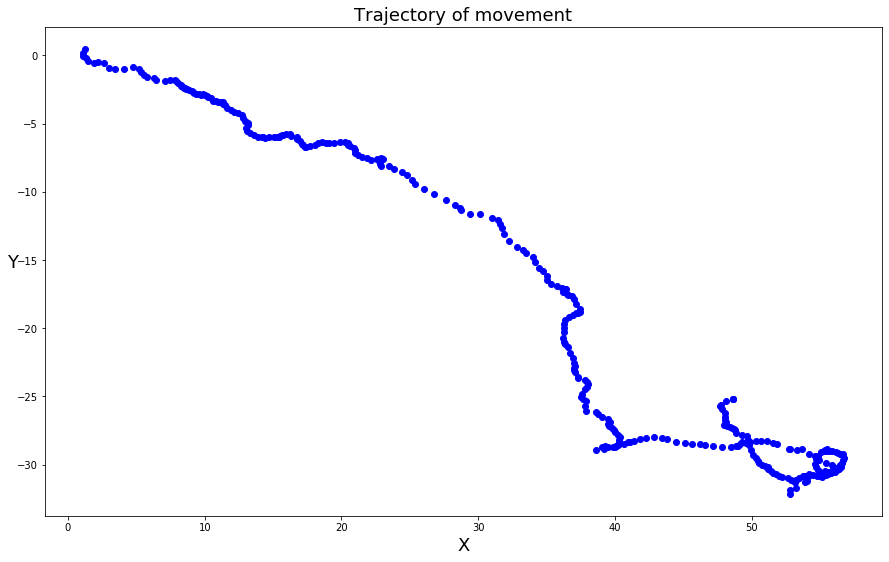

In [19]:
plt.figure(figsize = (15,9))
plt.title('Trajectory of movement', fontsize = 18)

plt.plot(trajectory[:,0],trajectory[:,1],'bo')
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=18, rotation = 0)

plt.show()

## Smoothed trajectory

In [20]:
def movingAverage(curve, radius): 
    window_size = 2 * radius + 1
    f = np.ones(window_size)/window_size 
    # Add padding to the boundaries 
    curve_pad = np.lib.pad(curve, (radius, radius), 'edge') 
    curve_smoothed = np.convolve(curve_pad, f, mode='same') 
    # Remove padding 
    curve_smoothed = curve_smoothed[radius:-radius]

    return curve_smoothed

In [21]:
# The larger the more stable the video, but less reactive to sudden panning
SMOOTHING_RADIUS=50 

def smooth(trajectory): 
    smoothed_trajectory = np.copy(trajectory) 
    # Filter the x, y and angle curves
    for i in range(3):
        smoothed_trajectory[:,i] = movingAverage(trajectory[:,i], radius=SMOOTHING_RADIUS)

    return smoothed_trajectory

# Create variable to store smoothed trajectory
smoothed_trajectory = smooth(trajectory) 

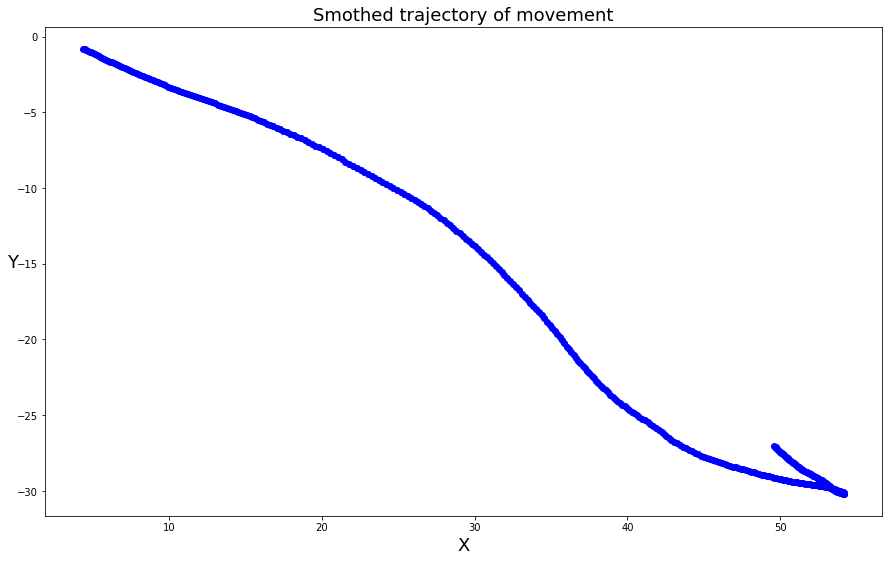

In [22]:
plt.figure(figsize = (15,9))
plt.title('Smothed trajectory of movement', fontsize = 18)

plt.plot(smoothed_trajectory[:,0],smoothed_trajectory[:,1],'bo')
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=18, rotation = 0)

plt.show()

In [23]:
print('X from {} to {}'.format(min(smoothed_trajectory[:,0]),max(smoothed_trajectory[:,0])))
print('Y from {} to {}'.format(min(smoothed_trajectory[:,1]),max(smoothed_trajectory[:,1])))

X from 4.355296611785889 to 54.16091537475586
Y from -30.174541473388672 to -0.8083748817443848


## Difference in trajectories

In [24]:
# Calculate difference in smoothed_trajectory and trajectory
difference = smoothed_trajectory - trajectory

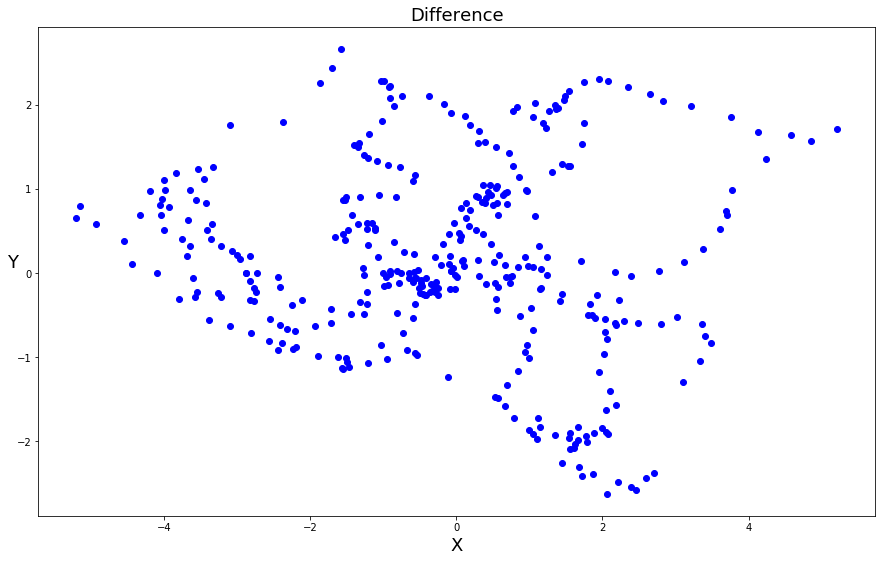

In [25]:
plt.figure(figsize = (15,9))
plt.title('Difference', fontsize = 18)

plt.plot(difference[:,0],difference[:,1],'bo')
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=18, rotation = 0)

plt.show()

## Smoothed transformation

In [26]:
 # Calculate newer transformation array
transforms_smooth = transforms + difference

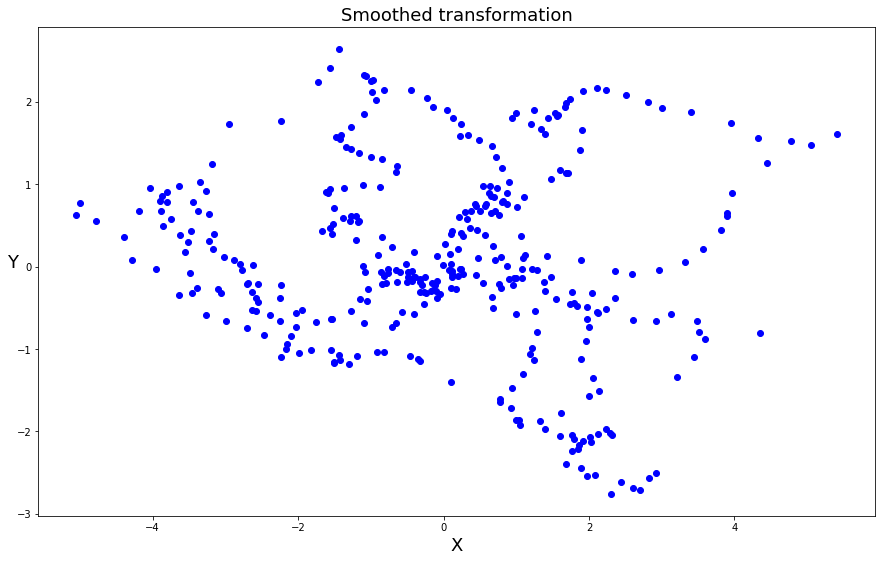

In [27]:
plt.figure(figsize = (15,9))
plt.title('Smoothed transformation', fontsize = 18)

plt.plot(transforms_smooth[:,0],transforms_smooth[:,1],'bo')
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=18, rotation = 0)

plt.show()

### Two previous graphs on one slide

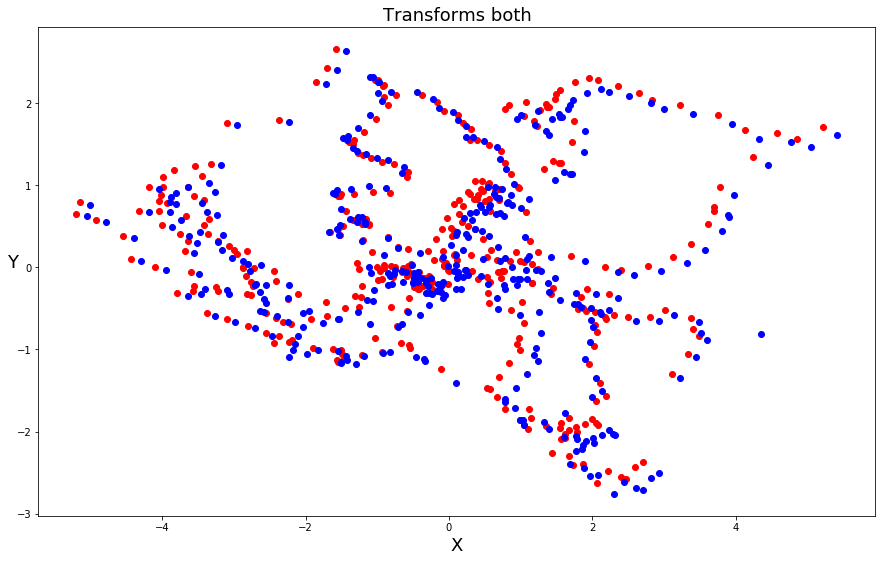

In [28]:
plt.figure(figsize = (15,9))
plt.title('Transforms both', fontsize = 18)
plt.plot(difference[:,0],difference[:,1],'ro')
plt.plot(transforms_smooth[:,0],transforms_smooth[:,1],'bo')
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=18, rotation = 0)

plt.show()

## Now we aply Transformation matrix to each frame via WarpAffine

If we have a motion specified as $(x, y, \theta)$, the corresponding transformation matrix is given by:

$$\begin{align*} T = \begin{bmatrix} \cos \theta & -\sin \theta & x \\ \sin \theta & \cos \theta & y \\ \end{bmatrix} \end{align*}$$

## We scale the image without moving the center and use method getRotationMatrix2D

In [29]:
def fixBorder(frame):
    s = frame.shape
    # Scale the image 4% without moving the center
    
    T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
    frame = cv2.warpAffine(frame, T, (s[1], s[0]))
    return frame

In [30]:
out = cv2.VideoWriter('output_data/vit_stabilized_{}.avi'.format(lvl), fourcc, fps, (2 * w, h))

In [31]:
# Reset stream to first frame 
cap.set(cv2.CAP_PROP_POS_FRAMES, 0) 

for i in range(n_frames-2):
    success, frame = cap.read() 
    if not success:
        break

    dx = transforms_smooth[i,0]
    dy = transforms_smooth[i,1]
    da = transforms_smooth[i,2]

    # Matrix T
    m = np.zeros((2,3), np.float32)
    m[0,0] = np.cos(da)
    m[0,1] = -np.sin(da)
    m[1,0] = np.sin(da)
    m[1,1] = np.cos(da)
    m[0,2] = dx
    m[1,2] = dy

    # Apply affine wrapping to the given frame
    frame_stabilized = cv2.warpAffine(frame, m, (w,h))
    frame_stabilized = fixBorder(frame_stabilized) 

    # Write the frame to the file
    frame_out = cv2.hconcat([frame, frame_stabilized])

    # If the image is too big, resize it.
    if(frame_out.shape[1] > 1920): 
        frame_out = cv2.resize(frame_out, (int(frame_out.shape[1]/2), int(frame_out.shape[0]/2)))

    cv2.imshow("Before and After", frame_out)
    cv2.waitKey(30)
    out.write(frame_out)
    

cap.release()
out.release()
cv2.destroyAllWindows()